### <font color='blue'>Análise de Sentimento em Avaliações de Usuários em Sites de Hotéis</font>

Link do dataset: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

### <font color='blue'>Instalando e Carregando Pacotes</font>

In [1]:
import re
import pickle
import nltk
import sklearn
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score

### <font color='blue'>Análise Exploratória e Limpeza dos Dados</font>

In [2]:
# Carregando o dataset
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [3]:
# Shape
df.shape

(20491, 2)

In [4]:
# Amostra dos dados
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Como primeira decisão, a coluna de Rating terá de ser convertida para que as avaliações sejam apenas positivas ou negativas, sendo assim, a decisão será que todas as avaliações que estão com rating de 1 à 3, serão consideradas negativas, e todas que foram avaliadas com 4 e 5 serão consideradas como positivas. Como os modelos de machine learning apenas aceitam números como entrada, tudo oque for negativo será zero, e positivo será 1 na coluna de Rating.

In [6]:
# Ajustando aa coluna
df['Rating'] = df['Rating'].map({1: 0,
                                 2: 0,
                                 3: 0,
                                 4: 1,
                                 5: 1})

In [7]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [8]:
# Verificando uma avaliação
df.Review[0]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [9]:
# Função de limpeza geral dos dados
def limpa_dados(texto):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned, '', texto)

A função acima recebe um argumento chamado texto, que é a string de texto a ser limpa. Dentro da função, a expressão regular r'<.*?>' é compilada. Esta expressão regular corresponde a qualquer coisa que esteja entre os caracteres < e >, incluindo os próprios caracteres de abertura e fechamento de tags. O ponto (.) corresponde a qualquer caractere (exceto quebras de linha), e o asterisco (*) indica que o caractere anterior (neste caso, o ponto) pode ocorrer zero ou mais vezes. O ponto de interrogação (?) torna a correspondência "preguiçosa", o que significa que ela corresponderá ao menor número possível de caracteres.

A função re.sub() é usada para substituir todas as ocorrências da expressão regular compilada (ou seja, as tags HTML) por uma string vazia (''). Isso efetivamente remove todas as tags HTML do texto. O texto limpo, sem as tags HTML, é retornado pela função.

In [10]:
# Testando a função
texto_com_tags = "<p>Este é um exemplo <b>com</b> tags HTML.</p>"
texto_limpo = limpa_dados(texto_com_tags)
print(texto_limpo)  

Este é um exemplo com tags HTML.


In [11]:
# Aplica a função no nosso dataset
df.Review = df.Review.apply(limpa_dados)

In [12]:
# Função para limpeza de caracteres especiais
def limpa_caracter_especial(texto):
    rem = ''
    for i in texto:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

Na função acima, a variável rem é inicializada como uma string vazia (''). Ela será usada para armazenar o texto resultante após a remoção dos caracteres especiais. A condição if i.isalnum() verifica se o caractere i é alfanumérico (ou seja, se é uma letra ou um número). A função isalnum() retorna True se o caractere for alfanumérico e False caso contrário. Se o caractere i for alfanumérico, ele é adicionado à variável rem. Se não for alfanumérico, um espaço (' ') é adicionado a rem no lugar do caractere especial. Após iterar por todos os caracteres da string texto, a função retorna a variável rem, que contém o texto com os caracteres especiais substituídos por espaços.

In [13]:
# Testando a função
texto_com_caracteres_especiais = "Olá, mundo! Como vai?"
texto_limpo = limpa_caracter_especial(texto_com_caracteres_especiais)
print(texto_limpo)

Olá  mundo  Como vai 


In [14]:
# Aplica a função
df.Review = df.Review.apply(limpa_caracter_especial)

In [15]:
# Função para converter o texto em minúsculo
def converte_minusculo(texto):
    return texto.lower()

Converter todo o texto para minúsculo ajuda a padronizar os dados, tornando-os mais consistentes. Isso é especialmente útil quando se lida com texto proveniente de diferentes fontes ou formatos.

In [16]:
# Testando a função
frase = "Esta é uma fraSE com LETRAS MaiúscuLAs"
frase_saida = converte_minusculo(frase)
print(frase_saida)

esta é uma frase com letras maiúsculas


In [17]:
# Aplica a função
df.Review = df.Review .apply(converte_minusculo)

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c2543367\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c2543367\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Função para remover stopwords
def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(str(texto))
    return[w for w in words if w not in stop_words]

A função acima utiliza a biblioteca NLTK (Natural Language Toolkit) para obter um conjunto de stopwords para o idioma inglês com stopwords.words('english'). Essas stopwords incluem palavras comuns como "the", "is", "in", etc., que geralmente não contribuem para o significado principal do texto em análises de PLN.

O texto é convertido em uma lista de palavras (ou "tokens") usando a função word_tokenize da NLTK. A função word_tokenize divide o texto em palavras com base em espaços e pontuação.

A list comprehension [w for w in words if w not in stop_words] é usada para criar uma nova lista de palavras que contém apenas aquelas palavras que não estão presentes no conjunto de stopwords. Ou seja, todas as palavras que são consideradas irrelevantes são removidas do texto.

In [20]:
# Testando a função
frase =  "They are right, as this is exactly what happened with me."
frase_saida = remove_stopwords(frase)
print(frase_saida)

['They', 'right', ',', 'exactly', 'happened', '.']


In [21]:
%%time
df.Review = df.Review.apply(remove_stopwords)

CPU times: total: 7.41 s
Wall time: 7.87 s


In [22]:
# Função para o stemmer
def stemmer(texto):
    objeto_stemmer = SnowballStemmer('english')
    return " ".join([objeto_stemmer.stem(w) for w in texto])

O "stemming" é uma técnica de Processamento de Linguagem Natural (PLN) usada para reduzir as palavras à sua forma raiz ou base, removendo prefixos e sufixos comuns. Isso ajuda a normalizar as palavras para análise e pode melhorar o desempenho de tarefas de PLN, como pesquisa de texto, classificação de texto e agrupamento de documentos.

A função acima recebe um argumento, que é a string de texto a ser processada. Um objeto SnowballStemmer é criado para o idioma inglês ('english'). Esse objeto será usado para realizar o stemming das palavras.

A função usa um list comprehension para aplicar o método stem do objeto SnowballStemmer a cada palavra no texto. O método stem reduz cada palavra à sua forma base. O texto é dividido em palavras assumindo que ele já está tokenizado (separado em palavras individuais). Se o texto não estiver tokenizado, você precisará fazer isso antes de aplicar o stemmer.

In [23]:
# Testando a função
texto = "The cats are running"
texto_stemmed = stemmer(texto.split())
print(texto_stemmed)  

the cat are run


In [24]:
%%time
df.Review = df.Review.apply(stemmer)

CPU times: total: 13.9 s
Wall time: 14.3 s


In [25]:
# Dados limpos
df.Review[0]

'nice hotel expens park got good deal stay hotel anniversari arriv late even took advic previous review valet park check quick easi littl disappoint non exist view room room clean nice size bed comfort woke stiff neck high pillow soundproof like heard music room night morn loud bang door open close hear peopl talk hallway mayb noisi neighbor aveda bath product nice goldfish stay nice touch taken advantag stay longer locat great walk distanc shop overal nice experi pay 40 park night'

### <font color='blue'>Pré-Processamento dos Dados</font>

In [26]:
# Aumentar o valor de max_colwidth para evitar truncagem
pd.set_option('display.max_colwidth', 120)

In [27]:
df.head()

,Review,Rating
0,nice hotel expens park got good deal stay hotel anniversari arriv late even took advic previous review valet park ch...,1
1,ok noth special charg diamond member hilton decid chain shot 20th anniversari seattl start book suit paid extra webs...,0
2,nice room 4 experi hotel monaco seattl good hotel n 4 level posit larg bathroom mediterranean suit comfort bed pillo...,0
3,uniqu great stay wonder time hotel monaco locat excel short stroll main downtown shop area pet friend room show sign...,1
4,great stay great stay went seahawk game awesom downfal view build n complain room huge staff help book hotel websit ...,1


In [28]:
# Extrai o texto da avaliação (entrada)
x = np.array(df.iloc[:,0].values)

In [29]:
# Extrai o sentimento (saída)
y = np.array(df.Rating.values)

In [30]:
# Divisão dos dados em treino e teste com proporção 80/20
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size = 0.2, random_state = 0)

In [31]:
# Cria um vetorizador (vai converter os dados de texto em representação numérica)
vetorizador = CountVectorizer(max_features = 1000)

In [32]:
# Fit e transform do vetorizador com dados de treino
x_treino_final = vetorizador.fit_transform(x_treino).toarray()

In [33]:
# Apenas transform nos dados de teste
x_teste_final = vetorizador.transform(x_teste).toarray()

In [34]:
print("x_treino_final:", x_treino_final.shape)
print("y_treino:", y_treino.shape)

x_treino_final: (16392, 1000)
y_treino: (16392,)


In [35]:
print(x_treino_final)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [36]:
print("x_teste_final:", x_teste_final.shape)
print("y_teste:", y_teste.shape)

x_teste_final: (4099, 1000)
y_teste: (4099,)


### <font color='blue'>Criação de Modelos de Machine Learning</font>

### Modelo Probabilístico 1 - GaussianNB

O Gaussian Naive Bayes (GaussianNB) é um modelo probabilístico baseado no teorema de Bayes, com a suposição de que as variáveis preditoras seguem uma distribuição gaussiana (normal). É frequentemente usado em problemas de classificação onde as características são contínuas e se presume que seguem uma distribuição normal. Este modelo é particularmente útil para classificar dados com características que variam de maneira contínua e são facilmente ajustáveis à curva gaussiana, tornando-o adequado para muitos cenários de Ciência de Dados e Machine Learning, especialmente em tarefas de classificação.

In [37]:
# Criar o modelo
modelo_v1 = GaussianNB()

In [38]:
# Treinando o modelo
modelo_v1.fit(x_treino_final, y_treino)

GaussianNB()

### Modelo Probabilístico 2 - MultinomialNB

Multinomial Naive Bayes (MultinomialNB) é outro modelo baseado no teorema de Bayes, mas é particularmente adequado para contar dados ou características que representam contagens ou frequências de eventos. Este modelo é comumente utilizado em tarefas de classificação de texto, onde as características podem ser, por exemplo, a frequência de palavras ou a contagem de termos em documentos. Ele lida bem com a característica de os dados serem representados em forma de vetores de contagens ou frequências, tornando-o altamente eficaz para a filtragem de spam, análise de sentimentos e categorização de documentos.

In [39]:
# Criando o modelo
modelo_v2 = MultinomialNB(alpha = 1.0, fit_prior = True)

In [40]:
# Treinando o modelo
modelo_v2.fit(x_treino_final, y_treino)

MultinomialNB()

### Modelo Probabilístico 3 - BernoulliNB

O Bernoulli Naive Bayes (BernoulliNB) é um modelo probabilístico que também utiliza o teorema de Bayes, mas é otimizado para dados binários/booleanos. Este modelo assume que todas as características são independentes e seguem uma distribuição de Bernoulli, o que significa que cada característica é representada por uma variável aleatória binária que pode assumir apenas dois possíveis resultados (por exemplo, 0 ou 1, verdadeiro ou falso). É particularmente útil em situações onde as características são explicitamente binárias, como em tarefas de classificação de texto, onde se considera apenas a presença ou ausência de uma palavra no documento, ignorando sua frequência.

In [41]:
# Cria o modelo
modelo_v3 = BernoulliNB(alpha = 1.0, fit_prior = True)

In [42]:
# Treina o modelo
modelo_v3.fit(x_treino_final, y_treino)

BernoulliNB()

### <font color='blue'>Avaliação, Interpretação e Comparação dos Modelos</font>

In [43]:
# Previsões com dados de teste
ypred_v1 = modelo_v1.predict(x_teste_final)

In [44]:
# Previsões com dados de teste
ypred_v2 = modelo_v2.predict(x_teste_final)

In [45]:
# Previsões com dados de teste
ypred_v3 = modelo_v3.predict(x_teste_final)

In [46]:
print("Acurácia do Modelo GaussianNB = ", round(accuracy_score(y_teste, ypred_v1) * 100, 2))
print("Acurácia do Modelo MultinomialNB = ", round(accuracy_score(y_teste, ypred_v2) * 100, 2))
print("Acurácia do Modelo BernoulliNB = ", round(accuracy_score(y_teste, ypred_v3) * 100, 2))

Acurácia do Modelo GaussianNB =  80.02
Acurácia do Modelo MultinomialNB =  85.92
Acurácia do Modelo BernoulliNB =  80.78


A acurácia é uma métrica global ideal para comparar versões do modelo do mesmo algoritmo. Para modelos de algoritmos diferentes a métrica AUC (Area Under The Curve) é a ideal.

In [47]:
# Import
from sklearn.metrics import roc_auc_score

In [48]:
# AUC do GaussianNB
y_proba = modelo_v1.predict_proba(x_teste_final)[:, 1]
auc1 = roc_auc_score(y_teste, y_proba)
print("AUC do Modelo GaussianNB =", round(auc1, 2))

AUC do Modelo GaussianNB = 0.79


In [49]:
# AUC do MultinomialNB
y_proba = modelo_v2.predict_proba(x_teste_final)[:, 1]
auc2 = roc_auc_score(y_teste, y_proba)
print("AUC do Modelo MultinomialNB =", round(auc2, 2))

AUC do Modelo MultinomialNB = 0.9


In [50]:
# AUC do BernoulliNB
y_proba = modelo_v3.predict_proba(x_teste_final)[:, 1]
auc3 = roc_auc_score(y_teste, y_proba)
print("AUC do Modelo BernoulliNB =", round(auc3, 2))

AUC do Modelo BernoulliNB = 0.87


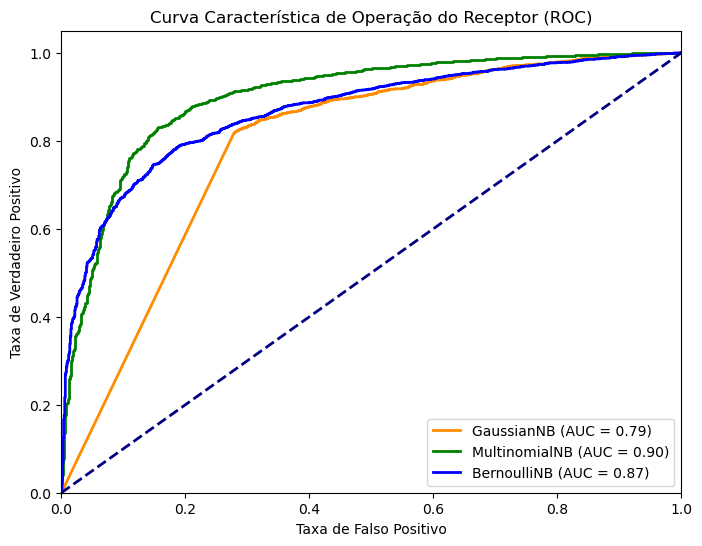

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Cria as curvas ROC para cada modelo
fpr1, tpr1, _ = roc_curve(y_teste, modelo_v1.predict_proba(x_teste_final)[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_teste, modelo_v2.predict_proba(x_teste_final)[:, 1])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_teste, modelo_v3.predict_proba(x_teste_final)[:, 1])
roc_auc3 = auc(fpr3, tpr3)

# Plota as curvas ROC
plt.figure(figsize=(8, 6))

plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'GaussianNB (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'MultinomialNB (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'BernoulliNB (AUC = {roc_auc3:.2f})')

# Linha diagonal tracejada representando um classificador aleatório
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')  # Traduzido
plt.ylabel('Taxa de Verdadeiro Positivo') # Traduzido
plt.title('Curva Característica de Operação do Receptor (ROC)') # Traduzido
plt.legend(loc="lower right") # Legenda no canto inferior direito para melhor visualização

plt.show()

A curva ROC é uma ferramenta estatística usada para avaliar a capacidade de um teste diagnóstico binário em discriminar entre duas classes (ex: doente e saudável). O gráfico plota a sensibilidade (taxa de verdadeiros positivos) versus 1 - especificidade (taxa de falsos positivos) para diferentes pontos de corte do teste. A área sob a curva (AUC) resume o desempenho do teste. Uma AUC de 1 representa um teste perfeito, enquanto 0.5 indica um teste equivalente ao acaso. A curva ROC auxilia na escolha do melhor ponto de corte, considerando o equilíbrio entre sensibilidade e especificidade, e na comparação entre diferentes testes diagnósticos. Também é usada para avaliar modelos de classificação em aprendizado de máquina e mineração de dados. Com base nisso, salvaremos o modelo 2, visto que ele apresentou os melhores resultados nos dois testes aplicados.

In [52]:
# Salva o melhor modelo em disco
with open('modelo_v2.pkl', 'wb') as arquivo:
    pickle.dump(modelo_v2, arquivo)

### <font color='blue'>Deploy e Uso do Modelo</font>

In [53]:
# Carrega o modelo do disco
with open('modelo_v2.pkl', 'rb') as arquivo:
    modelo_final = pickle.load(arquivo)

In [54]:
# Texto de uma avaliação de usuário (esse texto apresenta sentimento positivo)
texto_aval = """We love the Drury hotel, it’s one of our favourites to stay out when we go to Disney. We just spent seven days there and had a 
fantastic time apart from one night. At 2 o’clock in the morning the electricity in the whole hotel went out, including the air-conditioning, lights 
etc, and my husband has a CPAP machine that obviously stopped working, so he woke up choking in the middle of the night. Definitely not a good idea to 
do a fire /safety inspection/ whatever it was, in the middle of the night when people have O2 or machines they need to be able to sleep. Plus no AC in 
Florida which wasn’t comfortable. There was multiple guests at the front desk with the same problem that we had. It was out from 0200 until 0405."""

In [55]:
# Fluxo de transformação dos dados
tarefa1 = limpa_dados(texto_aval)
tarefa2 = limpa_caracter_especial(tarefa1)
tarefa3 = converte_minusculo(tarefa2)
tarefa4 = remove_stopwords(tarefa3)
tarefa5 = stemmer(tarefa4)

In [56]:
print(tarefa5)

love druri hotel one favourit stay go disney spent seven day fantast time apart one night 2 clock morn electr whole hotel went includ air condit light etc husband cpap machin obvious stop work woke choke middl night definit good idea fire safeti inspect whatev middl night peopl o2 machin need abl sleep plus ac florida comfort multipl guest front desk problem 0200 0405


In [57]:
# Convertendo a string para um array Numpy (pois foi assim que o modelo foi treinado)
tarefa5_array = np.array(tarefa5)

In [58]:
# Aplicamos o vetorizador com mais uma conversão para array NumPy a fim de ajustar o shape de 0-d para 1-d
aval_final = vetorizador.transform(np.array([tarefa5_array])).toarray()

In [59]:
# Previsão com o modelo
previsao = modelo_final.predict(aval_final.reshape(1,1000))

In [60]:
# Estrutura condicional para verificar o valor de previsao
if previsao == 1:
    print("O Texto Indica Sentimento Positivo!")
else:
    print("O Texto Indica Sentimento Negativo!")

O Texto Indica Sentimento Positivo!


Sites de hotéis utilizariam modelos de machine learning para avaliar o sentimento das avaliações por diversos motivos, visando aprimorar a experiência do hóspede, otimizar as operações e aumentar a receita. Aqui estão alguns dos principais motivos:

**Automação e Eficiência:** Processar manualmente um grande volume de avaliações pode ser demorado e caro. Modelos de machine learning podem automatizar esse processo, analisando rapidamente as avaliações e classificando-as como positivas, negativas ou neutras, economizando tempo e recursos.

**Identificação de Tendências e Padrões:** A análise automatizada permite identificar tendências e padrões nas avaliações, como reclamações recorrentes sobre determinados aspectos do hotel (limpeza, café da manhã, atendimento). Essa informação é crucial para direcionar melhorias e aprimorar a qualidade dos serviços oferecidos.

**Resposta Rápida a Problemas:** Modelos de machine learning podem ser configurados para alertar a gerência imediatamente sobre avaliações negativas que mencionam problemas urgentes, permitindo uma resposta rápida e eficiente, minimizando danos à reputação do hotel.

**Personalização da Experiência do Hóspede:** Ao analisar as avaliações, os modelos podem identificar as preferências e necessidades dos hóspedes, permitindo personalizar a experiência, oferecendo serviços e comodidades mais adequados a cada perfil.

**Melhoria da Reputação Online:** Responder a avaliações, especialmente as negativas, demonstra a preocupação do hotel com a satisfação dos hóspedes. A análise de sentimento permite priorizar as avaliações que exigem resposta imediata, contribuindo para melhorar a reputação online do hotel.

**Otimização de Preços e Receita:** Ao analisar as avaliações e o sentimento associado a diferentes faixas de preço, os hotéis podem ajustar suas estratégias de preços para maximizar a receita e a ocupação.

**Análise da Concorrência:** Os modelos podem ser usados para analisar as avaliações de hotéis concorrentes, identificando seus pontos fortes e fracos, permitindo ao hotel se posicionar melhor no mercado.

**Previsão da Demanda:** Ao combinar a análise de sentimento com outros dados, como sazonalidade e eventos locais, os hotéis podem prever a demanda futura, otimizando o gerenciamento de estoque e preços.

Em resumo, a utilização de machine learning para analisar avaliações oferece aos hotéis uma maneira eficiente e automatizada de obter insights valiosos sobre a experiência do hóspede, permitindo-lhes tomar decisões mais informadas para melhorar seus serviços, otimizar as operações e aumentar a receita.

### <font color='blue'>Sistema e Versões dos Pacotes</font>

In [61]:
%reload_ext watermark
%watermark -v -m
%watermark --iversions

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit

nltk      : 3.8.1
sklearn   : 1.4.2
pandas    : 2.2.2
re        : 2.2.1
numpy     : 1.26.4
matplotlib: 3.8.4

